In [1]:
import tensorflow.keras as keras
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
import json
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
BASE_PATH = '../Dataset/'

In [2]:
def generateModel(inputShape, lr=0.001):
    print("Generatin Model...")
    model = keras.models.Sequential()
    # first layer
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=inputShape,
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))

    # 2 con layer
    model.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu",
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))

    # 3 conv
    model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu",
                                  kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding="same"))

    #flatten layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.1))

    model.add(keras.layers.Dense(4, activation="softmax"))
    ## compile
    optimizer = keras.optimizers.Adam(lr)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    print(model.summary())
    return model

# Getting the trainig and Testing Data

In [3]:
from sklearn.model_selection import train_test_split
def get_train_and_test(filename, test_size, val_size):
    print("Getting the data ready...")
    le = LabelEncoder()
    with open(os.path.join(BASE_PATH, filename), 'r') as fp:
        data = json.load(fp)
    X = np.array(data["imageArray"])
    y = np.array(data["labels"])
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size,random_state=123)
    xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=val_size, random_state=123)
    class_names = np.unique(ytrain)
    ytrain = le.fit_transform(ytrain)
    ytest = le.transform(ytest)
    yval = le.transform(yval)
    return xtrain, xtest, xval, ytrain, ytest, yval, class_names

In [4]:
# json files
mfcc24 = BASE_PATH+"mfcc24.json"
mfcc48 = BASE_PATH+"mfcc48.json"
mfcc96 = BASE_PATH+"mfcc96.json"
mfccAll = BASE_PATH+"mfccCombined.json"

In [5]:
def get_splitted_data(json_file_name):
    test_size = 0.2
    val_size = 0.1
    # get_train_and_test(json_file_name, test_size, val_size)
    xtrain, xtest, xval, ytrain, ytest, yval, class_names = get_train_and_test(json_file_name, test_size, val_size)
    return xtrain, xtest, xval, ytrain, ytest, yval, class_names


def trainModel(xtrain, xtest, xval, ytrain, ytest, yval,epochs=30, modelName="1"):
    print("Trying To Train the Model...")
    lr = 0.001
    input_shape = xtrain[0].shape
    print(input_shape)
    model = generateModel(input_shape, lr)
    history = model.fit(xtrain, ytrain, batch_size=32, epochs=epochs, validation_data=(xval, yval))
    testError, testAcc = model.evaluate(xtest, ytest)
    print(f"Test error: {testError}, Test acc: {testAcc}")
    # modelName = jsonFileName.split(".")[0]
    model.save(f"{modelName}_dl.h5")
    return history
    # return None

In [6]:
import matplotlib.pyplot as plt
def plotHistory(hist):
    fig, axs = plt.subplots(2)
    # accuracy of
    axs[0].plot(hist.history['accuracy'], "g", label="Train Accuracy")
    axs[0].plot(hist.history['val_accuracy'], "b", label="Validation Accuracy")
    axs[0].set_title('Model Accuracies')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper left')
    # summarize history for loss
    axs[1].plot(hist.history['loss'], 'r', label="Train Loss")
    axs[1].plot(hist.history['val_loss'], 'b', label="Val Loss")
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='lower right')
    plt.show()

In [7]:
def plot_conf_matrix(predictions, ytest, labels):
    conf_mat = confusion_matrix(predictions, ytest)
    plot_confusion_matrix(conf_mat, show_normed=True, class_names=labels)

In [7]:
xtrain, xtest, xval, ytrain, ytest, yval, class_names = get_splitted_data(mfcc24)
mfcc24_history = trainModel(xtrain, xtest, xval, ytrain, ytest, yval,modelName="Mfcc 24 DL")

Getting the data ready...
Trying To Train the Model...
(127, 130, 3)
Generatin Model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 125, 128, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 62, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 62, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
__________________________________

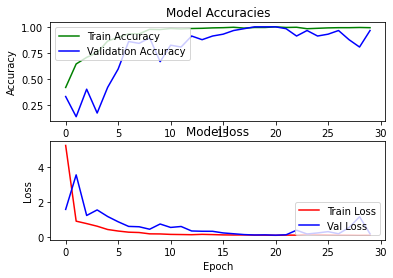

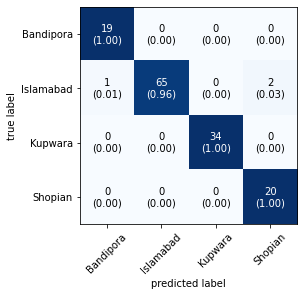

In [11]:
plotHistory(mfcc24_history)
model24 = keras.models.load_model("./Mfcc 24 DL_dl.h5")
pred_24 = model24.predict_classes(xtest)
plot_conf_matrix(pred_24, ytest, class_names)


In [13]:
xtrain, xtest, xval, ytrain, ytest, yval, class_names = get_splitted_data(mfcc48)
mfcc48_history = trainModel(xtrain, xtest, xval, ytrain, ytest, yval,modelName="Mfcc 48")


Getting the data ready...
Trying To Train the Model...
(127, 130, 3)
Generatin Model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 125, 128, 64)      1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 125, 128, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 62, 32)        18464     
_________________________________________________________________
batch_normalization_4 (Batch (None, 61, 62, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
________________________________

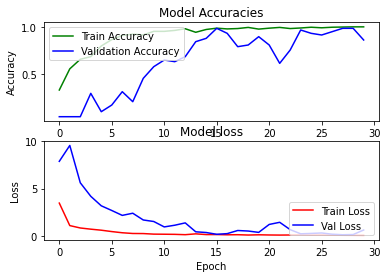

/Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


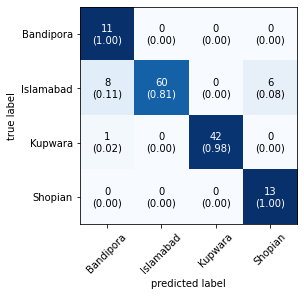

In [15]:
plotHistory(mfcc48_history)
model48 = keras.models.load_model("./Mfcc 48_dl.h5")
pred_48 = model48.predict_classes(xtest)
plot_conf_matrix(pred_48, ytest, class_names)

In [16]:
xtrain, xtest, xval, ytrain, ytest, yval, class_names = get_splitted_data(mfcc96)
mfcc96_history = trainModel(xtrain, xtest, xval, ytrain, ytest, yval,modelName="Mfcc 96")

Getting the data ready...
Trying To Train the Model...
(127, 130, 3)
Generatin Model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 125, 128, 64)      1792      
_________________________________________________________________
batch_normalization_6 (Batch (None, 125, 128, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 64, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 62, 32)        18464     
_________________________________________________________________
batch_normalization_7 (Batch (None, 61, 62, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
________________________________

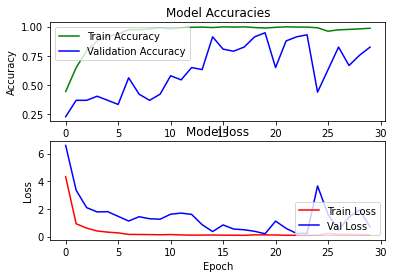

/Users/zean/Documents/Projects/Tensorflow/Master's Project/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


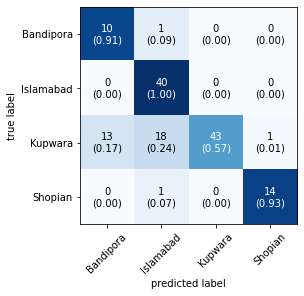

In [17]:
plotHistory(mfcc96_history)
model96 = keras.models.load_model("./Mfcc 96_dl.h5")
pred_96 = model96.predict_classes(xtest)
plot_conf_matrix(pred_96, ytest, class_names)


In [8]:
xtrain, xtest, xval, ytrain, ytest, yval, class_names = get_splitted_data(mfccAll)
mfccAll_history = trainModel(xtrain, xtest, xval, ytrain, ytest, yval,modelName="Mfcc All")

Getting the data ready...


FileNotFoundError: [Errno 2] No such file or directory: '../Dataset/../Dataset/mfccCombined.json'

In [ ]:
plotHistory(mfccAll_history)
model_all = keras.models.load_model("./Mfcc All_dl.h5")
pred_all = model_all.predict_classes(xtest)
plot_conf_matrix(pred_all, ytest, class_names)

# Model 1 - on 24 MFCCS


In [8]:
## rough
history24 = trainModel(mfcc24, epochs=20, "MFCC 24")

Trying To Train the Model...
Getting the data ready...
Generatin Model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 125, 128, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 62, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 62, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
________________________________________________

<Figure size 1080x720 with 0 Axes>

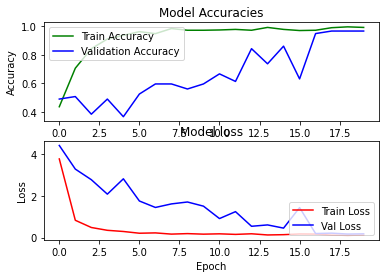

In [30]:
plotHistory(history24)

# model 2 - on 48 mfcc


In [14]:
history48 = trainModel(mfcc48, epochs=20, modelName = "MFCC 48")

Trying To Train the Model...
Getting the data ready...
Generatin Model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 125, 128, 64)      1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 125, 128, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 62, 32)        18464     
_________________________________________________________________
batch_normalization_4 (Batch (None, 61, 62, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
______________________________________________

<Figure size 1080x720 with 0 Axes>

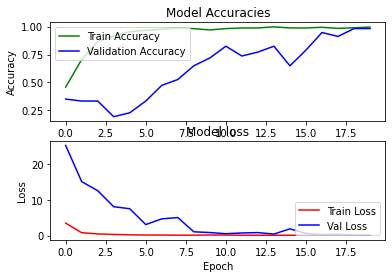

In [31]:
plotHistory(history48)

In [33]:
history96 = trainModel(mfcc96, epochs=20, modelName = 'MFCC 96')

Trying To Train the Model...
Getting the data ready...
Generatin Model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 125, 128, 64)      1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 125, 128, 64)      256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 64, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 62, 32)        18464     
_________________________________________________________________
batch_normalization_10 (Batc (None, 61, 62, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 32)        0         
______________________________________________

<Figure size 1080x720 with 0 Axes>

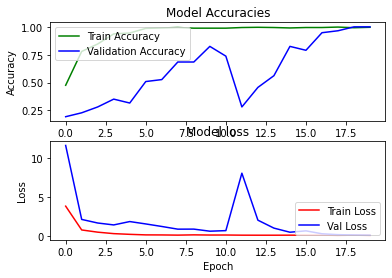

In [34]:
plotHistory(history96)

In [37]:
historyCom = trainModel(mfccAll, epochs=20, modelName = 'MFCC Combined')

Trying To Train the Model...
Getting the data ready...
Generatin Model...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 125, 128, 64)      1792      
_________________________________________________________________
batch_normalization_15 (Batc (None, 125, 128, 64)      256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 64, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 62, 32)        18464     
_________________________________________________________________
batch_normalization_16 (Batc (None, 61, 62, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 32)        0         
______________________________________________

<Figure size 1080x720 with 0 Axes>

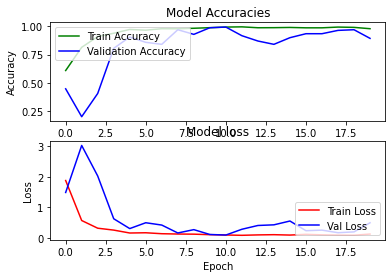

In [38]:
plotHistory(historyCom)

In [6]:
spectroJson = BASE_PATH+"spectrograms.json"

In [12]:
histSpec = trainModel(spectroJson, epochs=30, modelName = 'Mel Spectrogram')
# plotting
plotHistory(histSpec)

Trying To Train the Model...
Getting the data ready...


JSONDecodeError: Expecting ',' delimiter: line 186628760 column 26 (char 4279229060)